In [2]:
#imports
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask
#import the relevant dataset
print('begin')
path_to_file = "/fast/gmooers/Preprocessed_Data/Summer_Months/full_physics_essentials_valid_month02_targets.nc"
#path_to_file = "/fast/gmooers/Preprocessed_Data/MAPS_Vaild/full_physics_essentials_valid_month02_targets.nc"
ds = xr.open_dataset(path_to_file)
truths = ds.targets[:, -1].values
lons = ds.lon.values
lats = ds.lat.values
print('halfway')
path_to_file = "/fast/gmooers/Models/Relu_Leaky_Summer_both.nc"
#path_to_file = "/fast/gmooers/Models/Good_Summer.nc"
#path_to_file = "/fast/gmooers/Models/MAPS_Winter.nc"
ds = xr.open_dataset(path_to_file)
features = ds.Prediction[:, -1].values

x = 144
y = 96
z = 30
t = int(len(truths)/(x*y))
print(t)

dataset = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
lons = np.array(dataset.variables['lon'])
lats = np.array(dataset.variables['lat'])

begin
halfway
8831


In [3]:
reconstructed_features = np.zeros(shape=(t, y, x))
reconstructed_targets = np.zeros(shape=(t, y, x))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = features[count]
            B = truths[count]
            reconstructed_features[i, j, k] = A
            reconstructed_targets[i, j, k] = B
            count = count + 1
                
pred_data = reconstructed_features
truth_data = reconstructed_targets

In [4]:
ny = lats.size
nx = lons.size
nday = int(t/96)
nperday = 96


#Make an empty array of 0's by days, samples in a day, at each lat/lon coord
pred_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))
truth_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))

#loop over the number of days
count = 0
for i in range(len(pred_data_reorganized)):
    #loop over the samples per day
    for j in range(len(pred_data_reorganized[0])):
        pred_input_array = np.squeeze(pred_data[count , :, :])
        truth_input_array = np.squeeze(truth_data[count , :, :])
        pred_data_reorganized[i, j, :, :] = pred_input_array
        truth_data_reorganized[i, j, :, :] = truth_input_array
        count = count+1
        


In [5]:
#get the mean, standard devation from the reorganized data
#Do I need to add in a squeeze function?
truth_themean = np.nanmean(truth_data_reorganized, axis = 0)
truth_thestd = np.nanstd(truth_data_reorganized, axis = 0)

pred_themean = np.nanmean(pred_data_reorganized, axis = 0)
pred_thestd = np.nanstd(pred_data_reorganized, axis = 0)

In [6]:
#make arrays for the required maps
truth_amplitude_map = np.zeros(shape=(ny, nx))
truth_phase_map_utc = np.zeros(shape=(ny, nx))
truth_phase_map_lst = np.zeros(shape=(ny, nx))

pred_amplitude_map = np.zeros(shape=(ny, nx))
pred_phase_map_utc = np.zeros(shape=(ny, nx))
pred_phase_map_lst = np.zeros(shape=(ny, nx))


#get times into UTC
#dataset = netCDF4.Dataset("/fast/gmooers/Preprocessed_Data/PRECT_MAPS_rcat.nc")
dataset = netCDF4.Dataset("/fast/gmooers/Preprocessed_Data/PRECT_JJA_rcat.nc")
#!ncdump -h FLUT_JJA_rcat.nc

t = np.array(dataset.variables['time'])
utc_hour = (t[:96] - math.floor(t[0]))*24.0-0.125
utc_hour[0] = utc_hour[0]+24

In [7]:
#loop through longitudes
for i in range(len(pred_data_reorganized[0][0][0])):
    lst_hour = utc_hour +(lons[i]/360.)*24.
    lst_hour[lst_hour > 24] = lst_hour[lst_hour > 24] - 24
    
    #loop through latitudes
    for j in range(len(pred_data_reorganized[0][0])):
        truth_precip_cycle = np.squeeze(truth_themean[:, j, i])
        truth_amplitude_here = max(truth_precip_cycle)-min(truth_precip_cycle)
        truth_stderr_here = np.squeeze(max(truth_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        pred_precip_cycle = np.squeeze(pred_themean[:, j, i])
        pred_amplitude_here = max(pred_precip_cycle)-min(pred_precip_cycle)
        pred_stderr_here = np.squeeze(max(pred_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        #avoid high latitudes where unnesesary variation can occur
        
        if truth_amplitude_here >= 2.0*truth_stderr_here:
            truth_amplitude_map[j, i] = truth_amplitude_here
            #at what hour did max occur?
            if np.std(truth_precip_cycle) > 0.0:
                #b = max(precip_cycle)
                #index_max = np.where(precip_cycle = b)
                index_max = np.argmax(truth_precip_cycle)
                truth_phase_map_utc[j, i] = utc_hour[index_max]
                truth_phase_map_lst[j, i] = lst_hour[index_max]
                
        if pred_amplitude_here >= 2.0*pred_stderr_here:
            pred_amplitude_map[j, i] = pred_amplitude_here
            #at what hour did max occur?
            if np.std(pred_precip_cycle) > 0.0:
                #b = max(precip_cycle)
                #index_max = np.where(precip_cycle = b)
                index_max = np.argmax(pred_precip_cycle)
                pred_phase_map_utc[j, i] = utc_hour[index_max]
                pred_phase_map_lst[j, i] = lst_hour[index_max]
                

#generate apropriate lat/lon map
Xvar, Yvar = np.meshgrid(lons, lats)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


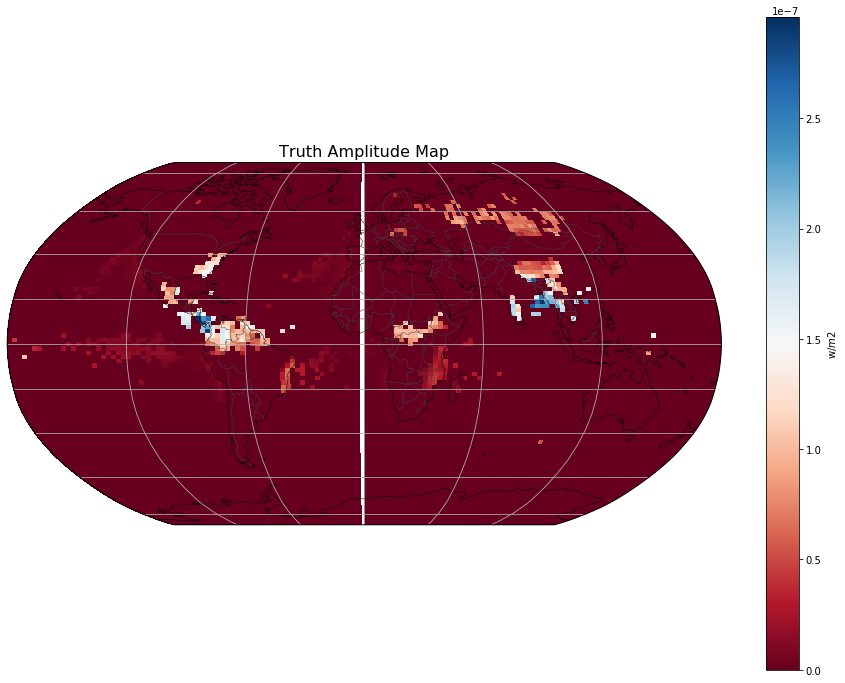

In [8]:
#New Figures
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
bm = Basemap()

fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
#ax1, ax2, ax3 = ax_array.flatten()
fig.set_size_inches(16,12)

#maxCol = 100
#minCol = -maxCol
contour_plot = ax1.pcolormesh(lons,lats, truth_amplitude_map,cmap='RdBu', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "w/$m$2")
ax1.set_title('Truth Amplitude Map')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#plt.savefig('/oasis/scratch/comet/gmooers/temp_project/SCRIPTS/Figures/OLR_AMP_Predict_n2.png')

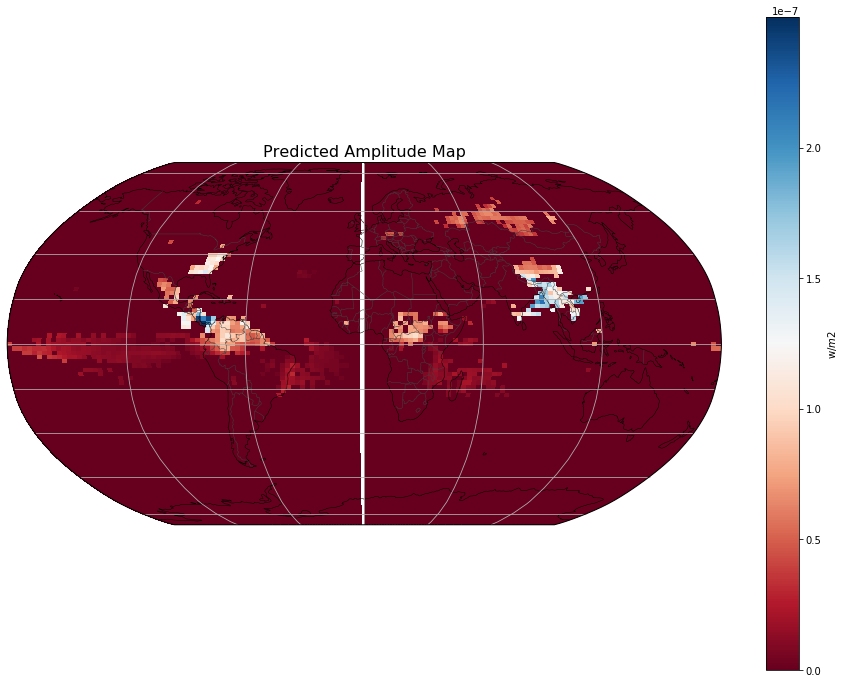

In [9]:
#New Figures
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
#ax1, ax2, ax3 = ax_array.flatten()
fig.set_size_inches(16,12)

#maxCol = 100
#minCol = -maxCol
contour_plot = ax1.pcolormesh(lons,lats, pred_amplitude_map,cmap='RdBu', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "w/$m$2")
ax1.set_title('Predicted Amplitude Map')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#plt.savefig('/oasis/scratch/comet/gmooers/temp_project/SCRIPTS/Figures/OLR_AMP_Predict_n2.png')

In [10]:
#add in nans
truth_nan_map_utc = truth_phase_map_utc 
truth_nan_map_lst = truth_phase_map_lst
for i in range(len(truth_phase_map_utc)):
    for j in range(len(truth_phase_map_utc[i])):
        if truth_phase_map_utc[i][j] == 0.0:
            truth_nan_map_utc[i][j] = np.nan
            truth_nan_map_lst[i][j] = np.nan

pred_nan_map_utc = pred_phase_map_utc 
pred_nan_map_lst = pred_phase_map_lst
for i in range(len(pred_phase_map_utc)):
    for j in range(len(pred_phase_map_utc[i])):
        if pred_phase_map_utc[i][j] == 0.0:
            pred_nan_map_utc[i][j] = np.nan
            pred_nan_map_lst[i][j] = np.nan
            
            
            
            

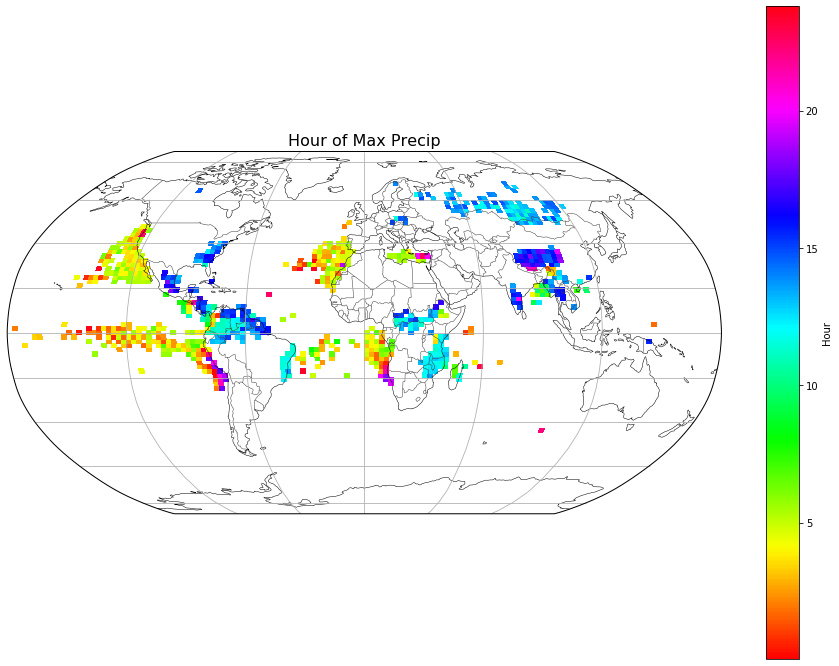

In [13]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
#ax2 = ax_array.flatten()
fig.set_size_inches(16,12)

#contour_plot = ax2.pcolormesh(lons,lats, nan_map_utc,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = 'Hour')
#ax2.set_title('UTC Map')
#ax2.title.set_fontsize(16)
#ax2.coastlines(linewidth=0.5,edgecolor='0.25')
#ax2.gridlines()
#ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


contour_plot = ax1.pcolormesh(lons,lats, truth_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = 'Hour')
ax1.set_title('Hour of Max Precip')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#plt.savefig("/oasis/scratch/comet/gmooers/temp_project/SCRIPTS/Figures/Good_Summer_Precip.png")

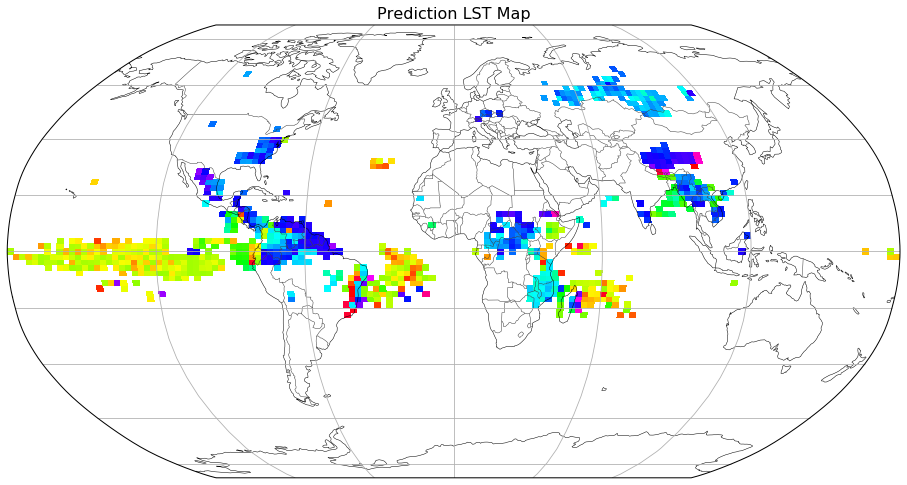

In [14]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
#ax2 = ax_array.flatten()
fig.set_size_inches(16,12)

#contour_plot = ax2.pcolormesh(lons,lats, nan_map_utc,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = 'Hour')
#ax2.set_title('UTC Map')
#ax2.title.set_fontsize(16)
#ax2.coastlines(linewidth=0.5,edgecolor='0.25')
#ax2.gridlines()
#ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


contour_plot = ax1.pcolormesh(lons,lats, pred_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
ax1.set_title('Prediction LST Map')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#plt.savefig("/oasis/scratch/comet/gmooers/temp_project/SCRIPTS/Figures/Good_Summer_Precip.png")

In [15]:
#np.save("/fast/gmooers/RG_Paper_Data/Summer_Precip_Cycle_Truth.npy",truth_nan_map_lst)
#np.save("/fast/gmooers/RG_Paper_Data/Summer_Precip_Cycle_Prediction.npy",pred_nan_map_lst)